In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from string import digits as d, punctuation as p
from nltk.tokenize import word_tokenize as wt
from nltk.stem import WordNetLemmatizer as wl, PorterStemmer as porter
from gensim import corpora

from sklearn.feature_extraction.text import TfidfVectorizer as tf
from sklearn.model_selection import train_test_split as tts, RandomizedSearchCV as rsv, cross_val_score as cvs
from sklearn.metrics import accuracy_score,classification_report,f1_score,auc,roc_curve,roc_auc_score,confusion_matrix,log_loss,\
precision_score,recall_score,mean_squared_error

from sklearn.linear_model import LogisticRegression,PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier

from PIL import Image
import requests
#from wordcloud import WordCloud

import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore',message="numpy.dtype size changed")
warnings.filterwarnings('ignore',message="numpy.ufunc size changed")
import joblib

In [1]:
import sys
print(sys.executable)

C:\Users\Prerna Jain\anaconda3\python.exe


In [4]:
/anaconda3/bin/python -m pip install wordcloud -m pip install some_package


NameError: name 'anaconda3' is not defined

In [5]:
/anaconda3/bin/python -m pip install wordcloud

NameError: name 'anaconda3' is not defined

In [5]:
# Loading the training data..
df=pd.read_csv('train.csv')
df.head()

,id,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [6]:
# Loading the test data..
test=pd.read_csv('test.csv')
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [7]:
print("In the training dataset\nNumber of columns=",df.shape[1],'\nNumber of Rows=',df.shape[0],'\nName of columns=\n',df.columns.values)

In the training dataset
Number of columns= 8 
Number of Rows= 159571 
Name of columns=
 ['id' 'comment_text' 'malignant' 'highly_malignant' 'rude' 'threat'
 'abuse' 'loathe']


In [8]:
print("In the test dataset\nNumber of columns=",test.shape[1],'\nNumber of Rows=',test.shape[0],'\nName of columns=\n',test.columns.values)

In the test dataset
Number of columns= 2 
Number of Rows= 153164 
Name of columns=
 ['id' 'comment_text']


In [9]:
#checking if there is any duplicated values in training dataset
print('Number of duplicated values:-',df.duplicated().sum())

Number of duplicated values:- 0


In [10]:
#checking if there is any duplicated values in test dataset
print('Number of duplicated values:-',test.duplicated().sum())

Number of duplicated values:- 0


In [11]:
#checking for null values in training dataset
for i in df.columns:
    null=df[i].isnull().sum()
    if null>0:
        print('Number of Null Values At  '+"'"+ i+"'" ,'==  ',null )
    else:
        print('There are no null values in  '+"'"+ i+"'")

There are no null values in  'id'
There are no null values in  'comment_text'
There are no null values in  'malignant'
There are no null values in  'highly_malignant'
There are no null values in  'rude'
There are no null values in  'threat'
There are no null values in  'abuse'
There are no null values in  'loathe'


In [12]:
#checking for null values in test dataset
for i in test.columns:
    null=test[i].isnull().sum()
    if null>0:
        print('Number of Null Values At  '+"'"+ i+"'" ,'==  ',null )
    else:
        print('There are no null values in  '+"'"+ i+"'")

There are no null values in  'id'
There are no null values in  'comment_text'


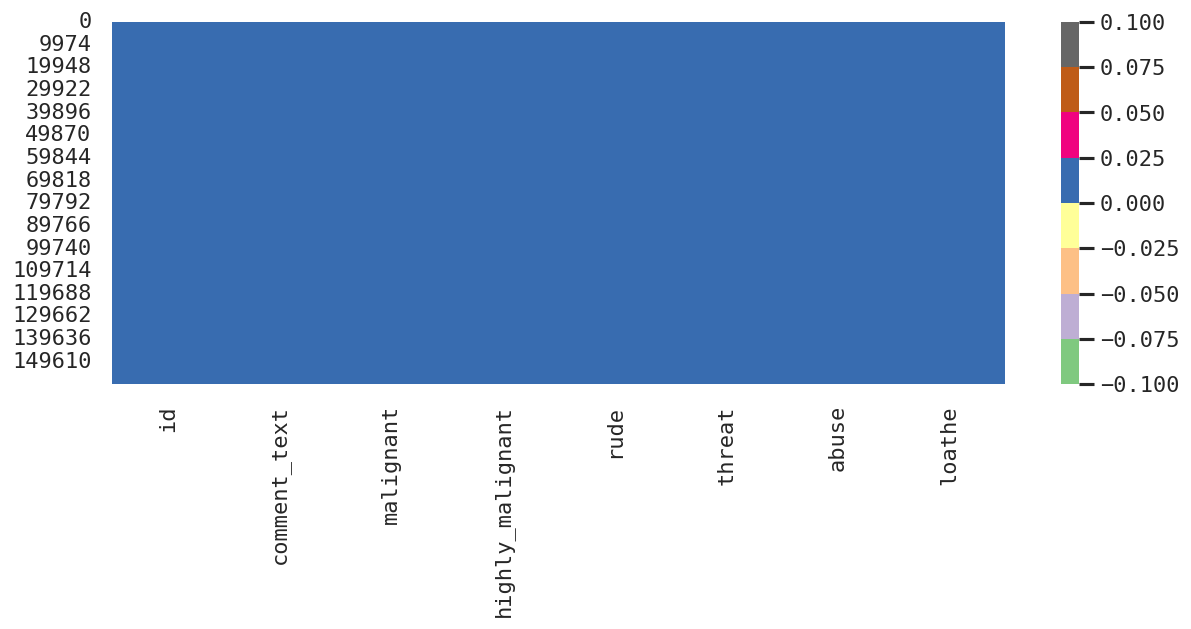

In [13]:
#heatmap of null values
sns.set(context='talk',style='whitegrid',palette='dark',font='monospace',font_scale=0.8)
plt.figure(figsize=(12,4),dpi=120)
sns.heatmap(df.isnull(),cmap='Accent')
plt.show()

Their is no null value in the dataset.

In [14]:
#dropping unwanted columns as we'll be working on the comment_text and their categories_
cmt=df.copy()
cmt.drop(['id'],axis=1,inplace=True)

In [15]:
test.drop(['id'],axis=1,inplace=True)

In [16]:
#adding a new column which represent a normal statement

labels= ['malignant','highly_malignant','rude','threat','abuse','loathe']
cmt['normal']=1-cmt[labels].max(axis=1)

In [17]:
cmt.head(7)

,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe,normal
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,1
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,1
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,1
5,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0,1
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,0


In [18]:
#adding a column 'raw length' to the dataset which will show the length of characters in column 'comment_text'
cmt['raw length']= cmt.comment_text.str.len().astype('int64')
cmt.head(7)

,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe,normal,raw length
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,1,264
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1,112
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1,233
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,1,622
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,1,67
5,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0,1,65
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,0,44


In [19]:
#value counts of  label columns
values=['malignant','highly_malignant','rude','threat','abuse','loathe']
for i in values:
    vc=cmt[i].value_counts()
    print('VALUE COUNT OF UNIQUE VALUES IN ' +"'"+ i+"' :\n ",vc,'\n')

VALUE COUNT OF UNIQUE VALUES IN 'malignant' :
  0    144277
1     15294
Name: malignant, dtype: int64 

VALUE COUNT OF UNIQUE VALUES IN 'highly_malignant' :
  0    157976
1      1595
Name: highly_malignant, dtype: int64 

VALUE COUNT OF UNIQUE VALUES IN 'rude' :
  0    151122
1      8449
Name: rude, dtype: int64 

VALUE COUNT OF UNIQUE VALUES IN 'threat' :
  0    159093
1       478
Name: threat, dtype: int64 

VALUE COUNT OF UNIQUE VALUES IN 'abuse' :
  0    151694
1      7877
Name: abuse, dtype: int64 

VALUE COUNT OF UNIQUE VALUES IN 'loathe' :
  0    158166
1      1405
Name: loathe, dtype: int64 



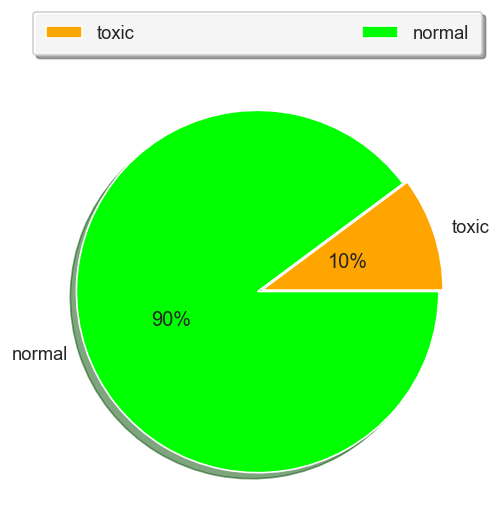

In [20]:
#Pie plot to show the percentage of toxic and normal comment
values=[cmt.shape[0]-cmt.normal.sum(),cmt.normal.sum()]
label=['toxic','normal']
exp=(0.025,0)
clr=('orange','lime')
plt.figure(figsize=(5,5),dpi=120)
sns.set_context('talk',font_scale=0.4)
sns.set(style='whitegrid')
plt.pie(x=values,explode=exp,labels=label,colors=clr,autopct='%2.0f%%',pctdistance=0.5, shadow=True,radius=1)
plt.legend(fancybox=True, framealpha=0.9, shadow=True, borderpad=0.7,bbox_to_anchor=(0., 1.02, 1., .102),ncol=2, mode="expand", borderaxespad=0.1)
plt.show()

In [21]:
#COUNT OF DIFFERENT LABELS
x=cmt.iloc[:,2:-1].sum()
x

highly_malignant      1595
rude                  8449
threat                 478
abuse                 7877
loathe                1405
normal              143346
dtype: int64

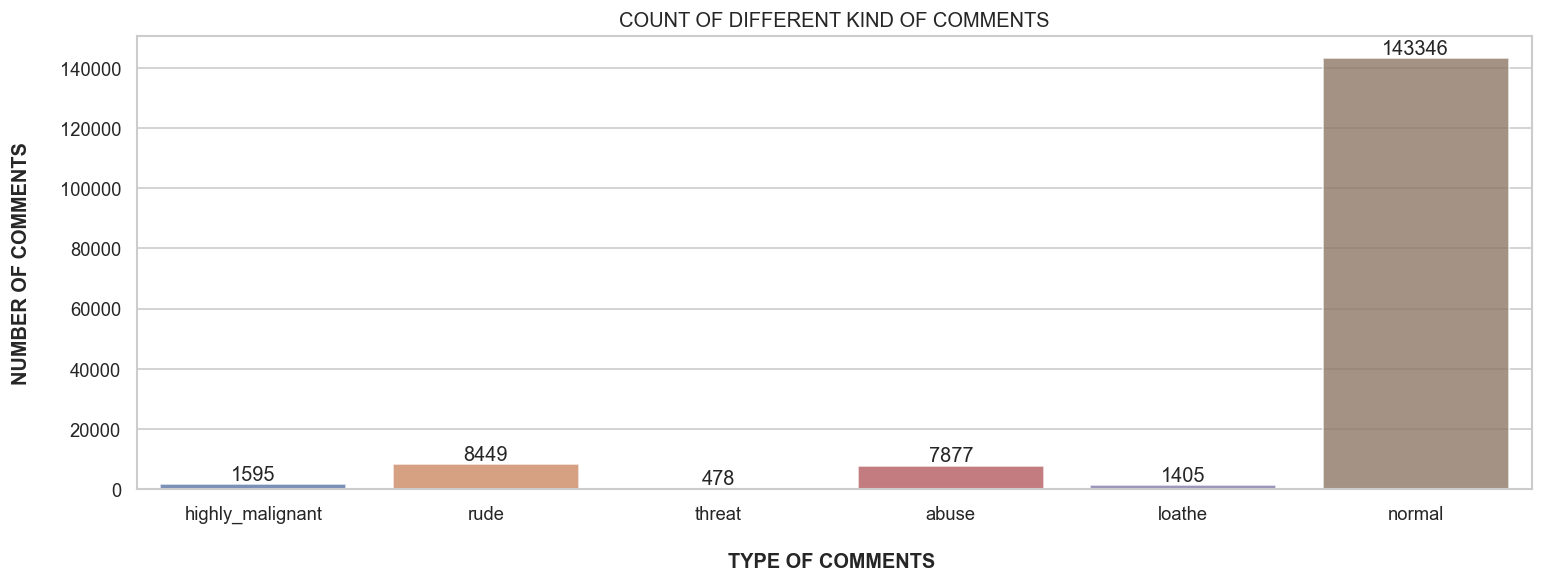

In [22]:
#COUNT OF LABELS
x=cmt.iloc[:,2:-1].sum() #not including comment_text and raw length column
plt.figure(figsize=(15,5),dpi=120)
sns.set_context('talk',font_scale=0.4)
sns.set(style='whitegrid')
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("COUNT OF DIFFERENT KIND OF COMMENTS")
plt.ylabel('NUMBER OF COMMENTS\n', fontsize=12,weight='bold')
plt.xlabel('\nTYPE OF COMMENTS ', fontsize=12,weight='bold')
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
plt.show()

In [23]:
#CHECKING THE COUNT OF COMMENTS WITH 1 OR MORE THAN 1 LABELS
summation=cmt.iloc[:,2:-1].sum(axis=1) #not including comment_text and raw length column
vc=summation.value_counts()
vc

1    147303
0      5666
2      4406
3      1780
4       385
5        31
dtype: int64

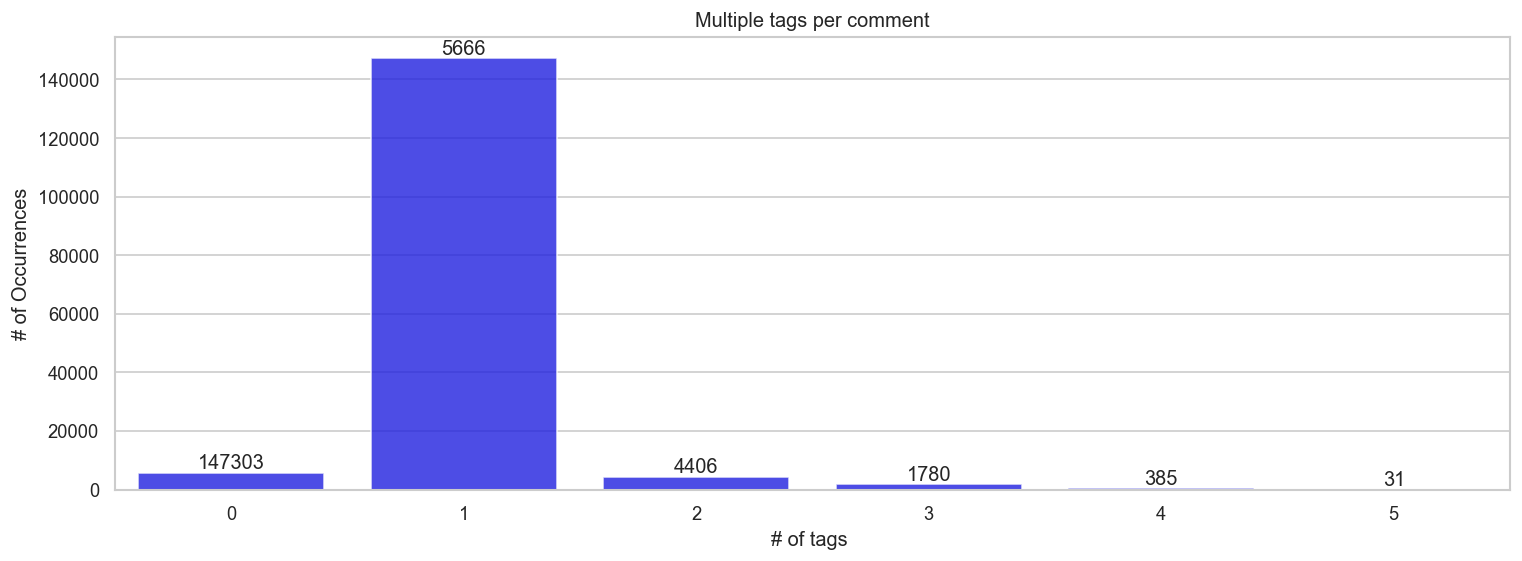

In [24]:
#PLOTTING NUMBERS OF COMMENTS WITH 1 OR MORE THAN 1 LABELS

plt.figure(figsize=(15,5),dpi=120)
sns.set_context('talk',font_scale=0.4)
sns.set(style='whitegrid')
ax=sns.barplot(x=vc.index, y=vc.values, alpha=0.8,color='blue')
plt.title("Multiple tags per comment")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of tags ', fontsize=12)
rects = ax.patches
labels = vc.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

In [25]:
cmt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   comment_text      159571 non-null  object
 1   malignant         159571 non-null  int64 
 2   highly_malignant  159571 non-null  int64 
 3   rude              159571 non-null  int64 
 4   threat            159571 non-null  int64 
 5   abuse             159571 non-null  int64 
 6   loathe            159571 non-null  int64 
 7   normal            159571 non-null  int64 
 8   raw length        159571 non-null  int64 
dtypes: int64(8), object(1)
memory usage: 11.0+ MB


In [26]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153164 entries, 0 to 153163
Data columns (total 1 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   comment_text  153164 non-null  object
dtypes: object(1)
memory usage: 1.2+ MB


In [28]:
cmt.describe()

,malignant,highly_malignant,rude,threat,abuse,loathe,normal,raw length
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805,0.898321,394.138847
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420,0.302226,590.725381
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,96.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,205.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,436.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5000.000000


In [29]:
#CREATING A FUNCTION TO PERFORM ASERIES OF OPERATIONS

def preprocess(text):
    processed=[]
    lower=text.lower().replace(r'\n'," ").replace(r'^.+@[^\.].*\.[a-z]{2,}$',' ').replace(r'^http://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$',' ')
    #converting to lower case and replacing mail id,links by white space
    
    text=lower.replace(r'\s+', ' ').replace(r'\d+(\.\d+)?', ' ')
    #removing \n,large white space and leading_trailing white spaces, numbers by white space
    
    text=lower.replace(r"[^a-zA-Z]+", " ").replace(r"—"," ").replace(r'“', ' ').replace(r'”',' ').replace('’',' ').replace(r'–',' ').replace('«', ' ').replace('»',' ')
    text=text.replace('®',' ').replace('´',' ').replace('·',' ').replace('½',' ').replace('¾',' ').replace('¤',' ')
    #removing special characters by single white space
    
   
   
    punct=text.translate(str.maketrans('', '', p))  #remove punctuation
    digit=punct.translate(str.maketrans('', '', d))       #remove digits if any
    word= wt(digit, "english")
    
    for i in word:
        if i not in stopwords and len(i)>=3 and len(i)<12:
            lemma=porter().stem(wl().lemmatize(i))
           # lemma=wl().lemmatize(i)
            #stem=porter.stem(lemma)
            processed.append(lemma)
    return (" ".join([x for x in processed])).strip()

In [30]:
#TESTING THE FUNCTION CREATED ABOVE
sample=" As much as human rights and ethnic rights should be respected, spray painting every possible detail of unverifiable information\
on the Rohingya, and getting around the verification by claiming that the information was destroyed by an interested party - \
are not valid reasons for having a list of villages where a certain group of people live. There is already a lot of articles on the \
Arakanese people and state that have no concern of the Rohingya but include them for the sake of brotherly respect - this is pushing the\
line a bit far. Rohingyas should be treated fairly - I do not contest that. But articles like this one - are pure self-pitying and clutters \
Wikipedia with absolutely useless information. I wonder when will somebody change the name of the article on Burma/Myanmar on \
wiki to ""Country where the Rohingya are Persecuted"".\nRather, a brief mention of where the Rohingyas reside should be placed if desired\
on the main article on Rakhine state - albeit short and concise, not dump an entire list of names copied directly from some publication.\nWith\
all due respect, this article should be deleted."

print("Original Document: \n",sample)

processed=[]
for word in sample.split(' '):
    processed.append(word)
print('\n',processed)
print("\n\nTokenized and lemmatized document: \n")
print(preprocess(sample))

Original Document: 
  As much as human rights and ethnic rights should be respected, spray painting every possible detail of unverifiable informationon the Rohingya, and getting around the verification by claiming that the information was destroyed by an interested party - are not valid reasons for having a list of villages where a certain group of people live. There is already a lot of articles on the Arakanese people and state that have no concern of the Rohingya but include them for the sake of brotherly respect - this is pushing theline a bit far. Rohingyas should be treated fairly - I do not contest that. But articles like this one - are pure self-pitying and clutters Wikipedia with absolutely useless information. I wonder when will somebody change the name of the article on Burma/Myanmar on wiki to Country where the Rohingya are Persecuted.
Rather, a brief mention of where the Rohingyas reside should be placed if desiredon the main article on Rakhine state - albeit short and conc

LookupError: 
**********************************************************************
  Resource [93mpunkt[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt/english.pickle[0m

  Searched in:
    - 'C:\\Users\\Prerna Jain/nltk_data'
    - 'C:\\Users\\Prerna Jain\\anaconda3\\nltk_data'
    - 'C:\\Users\\Prerna Jain\\anaconda3\\share\\nltk_data'
    - 'C:\\Users\\Prerna Jain\\anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Prerna Jain\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
    - ''
**********************************************************************


In [31]:
%%time
clean = []

for i in cmt.comment_text:
    clean.append(preprocess(i))

LookupError: 
**********************************************************************
  Resource [93mpunkt[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt/english.pickle[0m

  Searched in:
    - 'C:\\Users\\Prerna Jain/nltk_data'
    - 'C:\\Users\\Prerna Jain\\anaconda3\\nltk_data'
    - 'C:\\Users\\Prerna Jain\\anaconda3\\share\\nltk_data'
    - 'C:\\Users\\Prerna Jain\\anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Prerna Jain\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
    - ''
**********************************************************************


In [32]:
print("Length of cleaned text=\t",len(clean))
print(clean[37])

Length of cleaned text=	 0


IndexError: list index out of range

In [33]:
#USING THE EXTRACTED FEATURE AS ''comment" also adding an extra column to represent the length of string of the cleaned comments
processed = pd.DataFrame({'comment' : clean })
cmt['comment']= processed

cmt['len of cleaned comment']=cmt['comment'].str.len().astype('int64')
cmt.head(15)

AttributeError: Can only use .str accessor with string values!

In [ ]:
print('Original Length = ',cmt['raw length'].sum())
print('Clean Length =  ', cmt['len of cleaned comment'].sum())
print('Total Reduction = ',cmt['raw length'].sum()-cmt['len of cleaned comment'].sum())

In [ ]:
%%time
comments = []

for i in test.comment_text:
    comments.append(preprocess(i))

In [ ]:
# Visualizations

Pandas-Profiling is an open source Python module with which we can quickly do an exploratory data analysis with just a few lines of code. It generates interactive reports in web format that can be presented to any person, even if they don’t know programming. It also offers report generation for the dataset with lots of features and customizations for the report generated. In short, what pandas-profiling does is save us all the work of visualizing and understanding the distribution of each variable. It generates a report with all the information easily available.

In [34]:
pandas_profiling.ProfileReport(df)

NameError: name 'pandas_profiling' is not defined

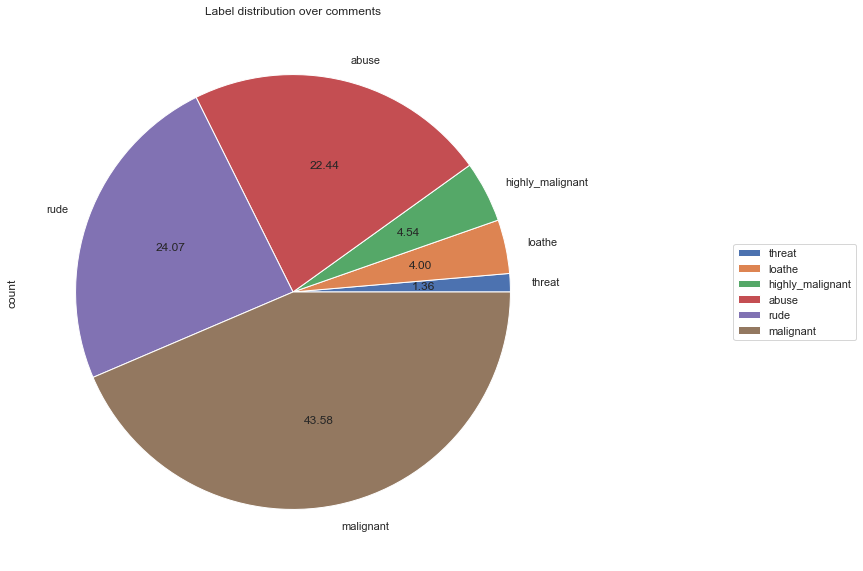

In [36]:
# Visualizing the label distribution of comments using pie chart
comments_labels = ['malignant', 'highly_malignant', 'rude', 'threat', 'abuse', 'loathe']
df_distribution = cmt[comments_labels].sum()\
                            .to_frame()\
                            .rename(columns={0: 'count'})\
                            .sort_values('count')

df_distribution.plot.pie(y = 'count', title = 'Label distribution over comments', autopct='%.2f', figsize = (15, 10))\
                            .legend(loc='center left', bbox_to_anchor=(1.3, 0.5))

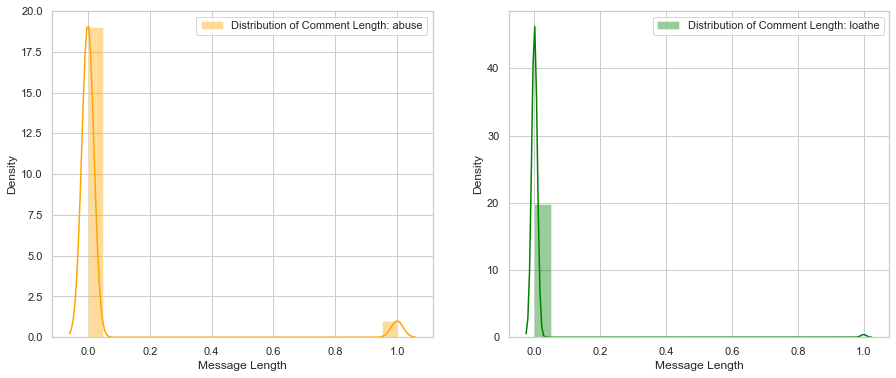

In [39]:
# Comparing the comment text length distribution before cleaning and after cleaning
fig, ax = plt.subplots(1,2,figsize=(15,6))
j=0
colors = ['orange','green']
for i in df.columns[-2:]:
    label_text = f"Distribution of Comment Length: {i}"
    sns.distplot(df[i],ax=ax[j],bins=20,color=colors[j],label=label_text)
    ax[j].set_xlabel("Message Length")
    ax[j].legend()
    j += 1
    
plt.show()

Before cleaning comment_text column most of the comment's length lies between 0 to 1100 while after cleaning it has been reduced between 0 to 900.

NameError: name 'output_labels' is not defined

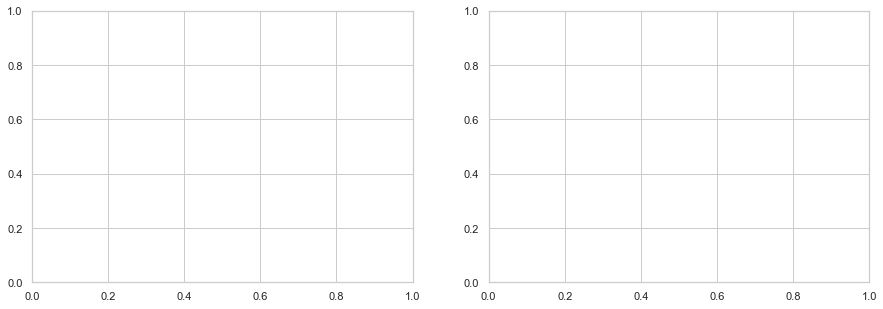

In [40]:
# comparing normal comments and bad comments using count plot
fig, ax = plt.subplots(1,2,figsize=(15,5))
for i in range(2):
    sns.countplot(data=df[output_labels][df[output_labels]==i], ax=ax[i])
    if i == 0:
        ax[i].set_title("Count Plot for Normal Comments\n")
    else:
        ax[i].set_title("Count Plot for Bad Comments\n")
        
    ax[i].set_xticklabels(output_labels, rotation=90, ha="right")
    p=0
    for prop in ax[i].patches:
        count = prop.get_height()
        s = f"{count} ({round(count*100/len(df),2)}%)"
        ax[i].text(p,count/2,s,rotation=90, ha="center", fontweight="bold")
        p += 1

plt.show()

Dataset consists of higher number of Normal Comments than Bad or Malignant Comments. Therefore, it is clear that dataset is imbalanced and needs to be handle accordingly. Most of the bad comments are of type malignant while least number of type threat is present in dataset. Majority of bad comments are of type malignant, rude and abuse.

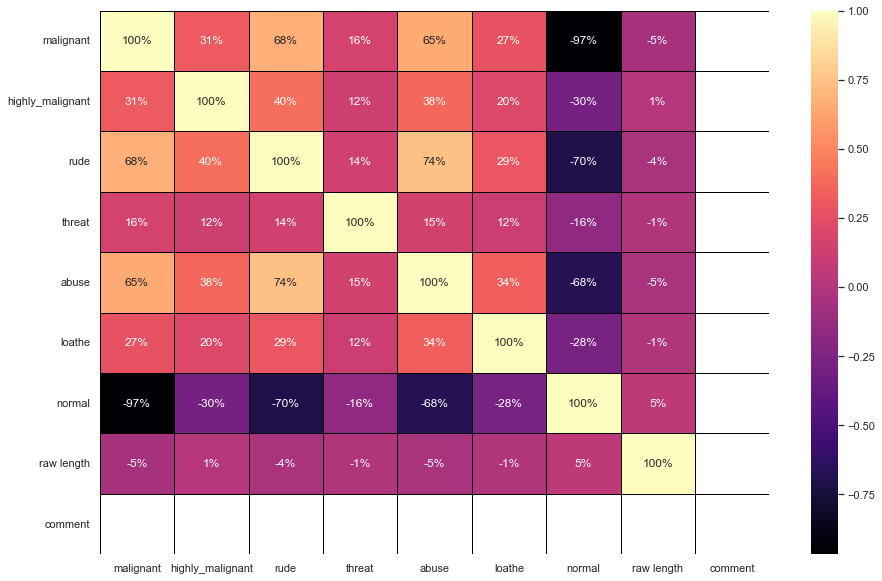

In [42]:
# Plotting heatmap for visualizing the correlation
plt.figure(figsize=(15, 10))
corr = cmt.corr() # corr() function provides the correlation value of each column
sns.heatmap(corr, linewidth=0.5, linecolor='black', fmt='.0%', cmap='magma', annot=True)
plt.show()

In [44]:
#USING THE EXTRACTED FEATURE AS ''comment" also adding an extra column to represent the length of string of the cleaned comments
processed = pd.DataFrame({'comment' : comment_text })
test['comment']= processed
test.head(5)

NameError: name 'comment_text' is not defined

In [45]:
malignant = cmt['comment'][cmt['malignant']==1]
wordcloud = WordCloud(width=700,height=500,background_color='black',max_words=50).generate(' '.join(malignant))
plt.figure(figsize = (7,5), facecolor = 'white', edgecolor='blue') 
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.title('WORD CLOUDS FOR MALIGNANT COMMENTS')
plt.show()

NameError: name 'WordCloud' is not defined

In [ ]:
highly_malignant = cmt['comment'][cmt['highly_malignant']==1]
wordcloud = WordCloud(width=700,height=500,background_color='black',max_words=50).generate(' '.join(highly_malignant))
plt.figure(figsize = (7,5), facecolor = 'white', edgecolor='blue') 
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.title('WORD CLOUDS FOR HIGHLY MALIGNANT COMMENTS')
plt.show()

In [ ]:
rude = cmt['comment'][cmt['rude']==1]
wordcloud = WordCloud(width=700,height=500,background_color='black',max_words=50).generate(' '.join(rude))
plt.figure(figsize = (7,5), facecolor = 'white', edgecolor='blue') 
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.title('WORD CLOUDS FOR RUDE COMMENTS')
plt.show()

In [ ]:
normal = cmt['comment'][cmt['normal']==1]
wordcloud = WordCloud(width=700,height=500,background_color='black',max_words=50).generate(' '.join(normal))
plt.figure(figsize = (7,5), facecolor = 'white', edgecolor='blue') 
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.title('WORD CLOUDS FOR NORMAL COMMENTS')
plt.show()

In [ ]:
# Model building

In [49]:
cmt.sample(4)

,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe,normal,raw length,comment
7549,"Arichnad|user]] • talk • contribs) 11:48, 3 Ju...",0,0,0,0,0,0,1,53,NaN
94788,HELLO AGAIN \n\ndont give a fcuk bull shit on ...,1,0,1,0,1,0,0,116,NaN
87857,"""\n Hey , before you attempt to make a patheti...",0,0,0,0,0,0,1,253,NaN
124571,"Exactly. Justinthebull, straw man arguments wi...",0,0,0,0,0,0,1,62,NaN


In [46]:
X=cmt.comment
y=cmt.iloc[:,1:-3]

In [47]:
X.head(4)

0   NaN
1   NaN
2   NaN
3   NaN
Name: comment, dtype: float64

In [48]:
y.head(4)

,malignant,highly_malignant,rude,threat,abuse,loathe
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0


In [50]:
tfidf=tf(input='content', encoding='utf-8', lowercase=True,stop_words='english',max_features=10000,ngram_range=(1,3))
x=tfidf.fit_transform(X).toarray()


AttributeError: 'float' object has no attribute 'lower'

In [ ]:
#CHECKING THE SELECTED FEATURE NAMES
tfidf.get_feature_names()[1:9]

In [ ]:
x_train,x_test,y_train,y_test=tts(x,y,test_size=0.30,random_state=95)

In [ ]:
print('shape of x_train:',x_train.shape,'\nshape of x_test:',x_test.shape)

print('shape of y_train:',y_train.shape,'\nshape of y_test:',y_test.shape)

In [ ]:
labels=['malignant','highly_malignant','rude','threat','abuse','loathe','normal']

In [ ]:
# LOGISTIC REGRESSION

In [ ]:
LogReg_pipeline = Pipeline([('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1))])
F1=[]
ACCURACY = []
PRECESION = []
RECALL = []
RMSE = []
MSE = []
AUC=[]
TPR=[]
FPR=[]
CV_ACC=[]
LOG_LOSS=[]

for category in labels:
    print('Processing {}'.format(category))
    print('-------------------------------------')
    LogReg_pipeline.fit(x_train, y_train[category])
    pred = LogReg_pipeline.predict(x_test)
    f1=f1_score(pred,y_test[category])
    acc=accuracy_score(pred,y_test[category])
    clr=classification_report(y_test[category],pred)
    pre=precision_score(y_test[category],pred)
    rec=recall_score(y_test[category],pred)
    mse=mean_squared_error(y_test[category],pred)
    rmse=np.sqrt(mse)
    log = log_loss( y_test[category],pred)
    auc_scr=roc_auc_score(y_test[category],pred)
    tpr,fpr,threshold=roc_curve(y_test[category],pred)
    conf=confusion_matrix(y_test[category],pred)
        

    print('ACCURACY SCORE:', acc)
    print('\nF1 score:',f1)
    print('\nCLASSIFICATION REPORT:\n',clr)
    print('\nPRECISION:\n',pre)
    print('\nRECALL:\n',rec)
    print('\nMEAN SQUARED ERROR:\n',mse)
    print('\nROOT MEAN SQ. ERROR:\n',rmse)
    print('\nLOG_LOSS:',log)
    print('\nAUC_ROC Score:\n',auc_scr)
    print('\nTPR:',tpr,'\nFPR:',fpr)
    
    print('\n')
    #plotting the auc_roc curve
    print('\n\n\t____________________________________________ROC_AUC CURVE_______________________________________________')
    print()
    sns.set(context='talk',style='whitegrid',palette='dark',font='monospace',font_scale=1)
    plt.figure(figsize=(8,3),dpi=120)
    plt.plot([0,1],[0,1],color='lime',linestyle=":",lw=3)
    plt.plot(tpr,fpr,label="AUC= %0.2f" % auc_scr,color='deepskyblue',lw=3,linestyle='--')
    plt.legend(fancybox=True,shadow=True, fontsize='medium')
    
    plt.xlabel("TPR",weight='bold',fontsize=10)
    plt.ylabel('FPR',weight='bold',fontsize=10)
    plt.title('RECEIVER OPERATING CHARACTERISTICS CURVE\n',size=10,weight='bold',loc='center')
    plt.show()
    print('\n')
    #plotting confusion matrix
    print('\n\n\t____________________________________________CONFUSION MATRIX___________________________________________\n')
    sns.set(context='talk',style='whitegrid',palette='dark',font='monospace',font_scale=1.3)
    plt.figure(figsize=(7,4),dpi=120)
    sns.heatmap(conf,annot=True,fmt='.2f',vmax=1,vmin=0,cmap='nipy_spectral',linewidths=0.8, linecolor='blue')
    plt.title('HEATMAP OF CONFUSION MATRIX\n',size=10,weight='bold',loc='center')
    plt.show()
    print('\n')
    
    ACCURACY.append(acc)
    F1.append(f1)
    PRECESION.append(pre)
    RECALL.append(rec)
    RMSE.append(rmse)
    MSE.append(mse)
    AUC.append(auc_scr)
    TPR.append(tpr)
    FPR.append(fpr)
    LOG_LOSS.append(log)
    
#creating a dataframe to show the performance of the model

logi_results = pd.DataFrame({"LABELS":labels,"F1":F1,'Acuracy':ACCURACY,'Precision': PRECESION ,'Recall': RECALL,
                               'RMSE':RMSE,'MSE':MSE,'AUC':AUC,'LOG_LOSS':LOG_LOSS})
                               
logi_results.style.set_properties(**{'background-color':'midnightblue','color': 'lime','border-color': 'darkorange'})           

In [ ]:
# PASSIVE AGGRESSIVE CLASSIFIER

In [ ]:
pac_pipeline = Pipeline([('clf', OneVsRestClassifier(PassiveAggressiveClassifier(), n_jobs=1))])
F1=[]
ACCURACY = []
PRECESION = []
RECALL = []
RMSE = []
MSE = []
AUC=[]
TPR=[]
FPR=[]
CV_ACC=[]
LOG_LOSS=[]
for category in labels:
    print('Processing {}'.format(category))
    print('-------------------------------------')
    pac_pipeline.fit(x_train, y_train[category])
    pred = pac_pipeline.predict(x_test)
    f1=f1_score(pred,y_test[category])
    acc=accuracy_score(pred,y_test[category])
    clr=classification_report(y_test[category],pred)
    pre=precision_score(y_test[category],pred)
    rec=recall_score(y_test[category],pred)
    mse=mean_squared_error(y_test[category],pred)
    rmse=np.sqrt(mse)
    log = log_loss( y_test[category],pred)
    auc_scr=roc_auc_score(y_test[category],pred)
    tpr,fpr,threshold=roc_curve(y_test[category],pred)
    conf=confusion_matrix(y_test[category],pred)
        

    print('ACCURACY SCORE:', acc)
    print('\nF1 score:',f1)
    print('\nCLASSIFICATION REPORT:\n',clr)
    print('\nPRECISION:\n',pre)
    print('\nRECALL:\n',rec)
    print('\nMEAN SQUARED ERROR:\n',mse)
    print('\nROOT MEAN SQ. ERROR:\n',rmse)
    print('\nLOG_LOSS:',log)
    print('\nAUC_ROC Score:\n',auc_scr)
    print('\nTPR:',tpr,'\nFPR:',fpr)
    print('\n')
    #plotting the auc_roc curve
    print('\n\n\t____________________________________________ROC_AUC CURVE_______________________________________________')
    print()
    sns.set(context='talk',style='whitegrid',palette='dark',font='monospace',font_scale=1)
    plt.figure(figsize=(8,3),dpi=120)
    plt.plot([0,1],[0,1],color='lime',linestyle=":",lw=3)
    plt.plot(tpr,fpr,label="AUC= %0.2f" % auc_scr,color='deepskyblue',lw=3,linestyle='--')
    plt.legend(fancybox=True,shadow=True, fontsize='medium')
    
    plt.xlabel("TPR",weight='bold',fontsize=10)
    plt.ylabel('FPR',weight='bold',fontsize=10)
    plt.title('RECEIVER OPERATING CHARACTERISTICS CURVE\n',size=10,weight='bold',loc='center')
    plt.show()
    print('\n')
  #plotting confusion matrix
    print('\n\n\t____________________________________________CONFUSION MATRIX___________________________________________\n')
    sns.set(context='talk',style='whitegrid',palette='dark',font='monospace',font_scale=1)
    plt.figure(figsize=(7,5),dpi=100)
    sns.heatmap(conf,annot=True,fmt='.2f',vmax=1,vmin=0,cmap='nipy_spectral',linewidths=0.8, linecolor='blue')
    plt.title('HEATMAP OF CONFUSION MATRIX\n',size=18,weight='bold',loc='center')
    plt.show()
    print('\n')
    
    ACCURACY.append(acc)
    F1.append(f1)
    PRECESION.append(pre)
    RECALL.append(rec)
    RMSE.append(rmse)
    MSE.append(mse)
    AUC.append(auc_scr)
    TPR.append(tpr)
    FPR.append(fpr)
    LOG_LOSS.append(log)
    
#creating a dataframe to show the performance of the model

pac_results = pd.DataFrame({"LABELS":labels,"F1":F1,'Acuracy':ACCURACY,'Precision': PRECESION ,'Recall': RECALL,
                               'RMSE':RMSE,'MSE':MSE,'AUC':AUC,'LOG_LOSS':LOG_LOSS})
                               
pac_results.style.set_properties(**{'background-color':'black','color': 'lime','border-color': 'darkorange'})                                

In [ ]:
# MULTINOMIAL NB

In [ ]:
MNB_pipeline = Pipeline([('clf', OneVsRestClassifier(MultinomialNB(fit_prior=True, class_prior=None), n_jobs=-1))])
F1=[]
ACCURACY = []
PRECESION = []
RECALL = []
RMSE = []
MSE = []
AUC=[]
TPR=[]
FPR=[]
CV_ACC=[]
LOG_LOSS=[]
for category in labels:
    print('Processing {}'.format(category))
    print('-------------------------------------')
    MNB_pipeline.fit(x_train, y_train[category])
    pred = MNB_pipeline.predict(x_test)
    f1=f1_score(pred,y_test[category])
    acc=accuracy_score(pred,y_test[category])
    clr=classification_report(y_test[category],pred)
    pre=precision_score(y_test[category],pred)
    rec=recall_score(y_test[category],pred)
    mse=mean_squared_error(y_test[category],pred)
    rmse=np.sqrt(mse)
    log = log_loss( y_test[category],pred)
    auc_scr=roc_auc_score(y_test[category],pred)
    tpr,fpr,threshold=roc_curve(y_test[category],pred)
    conf=confusion_matrix(y_test[category],pred)
        

    print('ACCURACY SCORE:', acc)
    print('\nF1 score:',f1)
    print('\nCLASSIFICATION REPORT:\n',clr)
    print('\nPRECISION:\n',pre)
    print('\nRECALL:\n',rec)
    print('\nMEAN SQUARED ERROR:\n',mse)
    print('\nROOT MEAN SQ. ERROR:\n',rmse)
    print('\nLOG_LOSS:',log)
    print('\nAUC_ROC Score:\n',auc_scr)
    print('\nTPR:',tpr,'\nFPR:',fpr)
    print('\n')
    #plotting the auc_roc curve
    print('\n\n\t____________________________________________ROC_AUC CURVE_______________________________________________')
    print()
    sns.set(context='talk',style='whitegrid',palette='dark',font='monospace',font_scale=1)
    plt.figure(figsize=(8,3),dpi=120)
    plt.plot([0,1],[0,1],color='lime',linestyle=":",lw=3)
    plt.plot(tpr,fpr,label="AUC= %0.2f" % auc_scr,color='deepskyblue',lw=3,linestyle='--')
    plt.legend(fancybox=True,shadow=True, fontsize='medium')
    
    plt.xlabel("TPR",weight='bold',fontsize=10)
    plt.ylabel('FPR',weight='bold',fontsize=10)
    plt.title('RECEIVER OPERATING CHARACTERISTICS CURVE\n',size=10,weight='bold',loc='center')
    plt.show()
    print('\n')
  #plotting confusion matrix
    print('\n\n\t____________________________________________CONFUSION MATRIX___________________________________________\n')
    sns.set(context='talk',style='whitegrid',palette='dark',font='monospace',font_scale=1.3)
    plt.figure(figsize=(7,5),dpi=120)
    sns.heatmap(conf,annot=True,fmt='.2f',vmax=1,vmin=0,cmap='nipy_spectral',linewidths=0.8, linecolor='blue')
    plt.title('HEATMAP OF CONFUSION MATRIX\n',size=18,weight='bold',loc='center')
    plt.show()
    print('\n')
    
    ACCURACY.append(acc)
    F1.append(f1)
    PRECESION.append(pre)
    RECALL.append(rec)
    RMSE.append(rmse)
    MSE.append(mse)
    AUC.append(auc_scr)
    TPR.append(tpr)
    FPR.append(fpr)
    LOG_LOSS.append(log)
    
#creating a dataframe to show the performance of the model

mnb_results = pd.DataFrame({"LABELS":labels,"F1":F1,'Acuracy':ACCURACY,'Precision': PRECESION ,'Recall': RECALL,
                               'RMSE':RMSE,'MSE':MSE,'AUC':AUC,'LOG_LOSS':LOG_LOSS})
                               
mnb_results.style.set_properties(**{'background-color':'black','color': 'lime','border-color': 'darkorange'})      

In [ ]:
# COMPLEMENT NB

In [ ]:
CNB_pipeline = Pipeline([('clf', OneVsRestClassifier(ComplementNB(fit_prior=True, class_prior=None), n_jobs=-1))])
F1=[]
ACCURACY = []
PRECESION = []
RECALL = []
RMSE = []
MSE = []
AUC=[]
TPR=[]
FPR=[]
CV_ACC=[]
LOG_LOSS=[]
for category in labels:
    print('Processing {}'.format(category))
    print('-------------------------------------')
    CNB_pipeline.fit(x_train, y_train[category])
    pred = CNB_pipeline.predict(x_test)
    f1=f1_score(pred,y_test[category])
    acc=accuracy_score(pred,y_test[category])
    clr=classification_report(y_test[category],pred)
    pre=precision_score(y_test[category],pred)
    rec=recall_score(y_test[category],pred)
    mse=mean_squared_error(y_test[category],pred)
    rmse=np.sqrt(mse)
    log = log_loss( y_test[category],pred)
    auc_scr=roc_auc_score(y_test[category],pred)
    tpr,fpr,threshold=roc_curve(y_test[category],pred)
    conf=confusion_matrix(y_test[category],pred)
        

    print('ACCURACY SCORE:', acc)
    print('\nF1 score:',f1)
    print('\nCLASSIFICATION REPORT:\n',clr)
    print('\nPRECISION:\n',pre)
    print('\nRECALL:\n',rec)
    print('\nMEAN SQUARED ERROR:\n',mse)
    print('\nROOT MEAN SQ. ERROR:\n',rmse)
    print('\nLOG_LOSS:',log)
    print('\nAUC_ROC Score:\n',auc_scr)
    print('\nTPR:',tpr,'\nFPR:',fpr)
    print('\n')
    #plotting the auc_roc curve
    print('\n\n\t____________________________________________ROC_AUC CURVE_______________________________________________')
    print()
    sns.set(context='talk',style='whitegrid',palette='dark',font='monospace',font_scale=1)
    plt.figure(figsize=(8,3),dpi=120)
    plt.plot([0,1],[0,1],color='lime',linestyle=":",lw=3)
    plt.plot(tpr,fpr,label="AUC= %0.2f" % auc_scr,color='deepskyblue',lw=3,linestyle='--')
    plt.legend(fancybox=True,shadow=True, fontsize='medium')
    
    plt.xlabel("TPR",weight='bold',fontsize=10)
    plt.ylabel('FPR',weight='bold',fontsize=10)
    plt.title('RECEIVER OPERATING CHARACTERISTICS CURVE\n',size=10,weight='bold',loc='center')
    plt.show()
    print('\n')
  #plotting confusion matrix
    print('\n\n\t____________________________________________CONFUSION MATRIX___________________________________________\n')
    sns.set(context='talk',style='whitegrid',palette='dark',font='monospace',font_scale=1.3)
    plt.figure(figsize=(7,4),dpi=120)
    sns.heatmap(conf,annot=True,fmt='.2f',vmax=1,vmin=0,cmap='nipy_spectral',linewidths=0.8, linecolor='blue')
    plt.title('HEATMAP OF CONFUSION MATRIX\n',size=18,weight='bold',loc='center')
    plt.show()
    print('\n')
    ACCURACY.append(acc)
    F1.append(f1)
    PRECESION.append(pre)
    RECALL.append(rec)
    RMSE.append(rmse)
    MSE.append(mse)
    AUC.append(auc_scr)
    TPR.append(tpr)
    FPR.append(fpr)
    LOG_LOSS.append(log)
    
#creating a dataframe to show the performance of the model
cnb_results = pd.DataFrame({"LABELS":labels,"F1":F1,'Acuracy':ACCURACY,'Precision': PRECESION ,'Recall': RECALL,
                               'RMSE':RMSE,'MSE':MSE,'AUC':AUC,'LOG_LOSS':LOG_LOSS})
                               
cnb_results.style.set_properties(**{'background-color':'black','color': 'lime','border-color': 'darkorange'})                                

In [ ]:
# LINEAR SVC

In [ ]:
svc_pipeline = Pipeline([('clf', OneVsRestClassifier(ComplementNB(fit_prior=True, class_prior=None), n_jobs=-1))])
F1=[]
ACCURACY = []
PRECESION = []
RECALL = []
RMSE = []
MSE = []
AUC=[]
TPR=[]
FPR=[]
CV_ACC=[]
LOG_LOSS=[]
for category in labels:
    print('Processing {}'.format(category))
    print('-------------------------------------')
    svc_pipeline.fit(x_train, y_train[category])
    pred = svc_pipeline.predict(x_test)
    f1=f1_score(pred,y_test[category])
    acc=accuracy_score(pred,y_test[category])
    clr=classification_report(y_test[category],pred)
    pre=precision_score(y_test[category],pred)
    rec=recall_score(y_test[category],pred)
    mse=mean_squared_error(y_test[category],pred)
    rmse=np.sqrt(mse)
    log = log_loss( y_test[category],pred)
    auc_scr=roc_auc_score(y_test[category],pred)
    tpr,fpr,threshold=roc_curve(y_test[category],pred)
    conf=confusion_matrix(y_test[category],pred)
        

    print('ACCURACY SCORE:', acc)
    print('\nF1 score:',f1)
    print('\nCLASSIFICATION REPORT:\n',clr)
    print('\nPRECISION:\n',pre)
    print('\nRECALL:\n',rec)
    print('\nMEAN SQUARED ERROR:\n',mse)
    print('\nROOT MEAN SQ. ERROR:\n',rmse)
    print('\nLOG_LOSS:',log)
    print('\nAUC_ROC Score:\n',auc_scr)
    print('\nTPR:',tpr,'\nFPR:',fpr)
    print('\n')
    #plotting the auc_roc curve
    print('\n\n\t____________________________________________ROC_AUC CURVE_______________________________________________')
    print()
    sns.set(context='talk',style='whitegrid',palette='dark',font='monospace',font_scale=1)
    plt.figure(figsize=(8,3),dpi=120)
    plt.plot([0,1],[0,1],color='lime',linestyle=":",lw=3)
    plt.plot(tpr,fpr,label="AUC= %0.2f" % auc_scr,color='deepskyblue',lw=3,linestyle='--')
    plt.legend(fancybox=True,shadow=True, fontsize='medium')
    
    plt.xlabel("TPR",weight='bold',fontsize=10)
    plt.ylabel('FPR',weight='bold',fontsize=10)
    plt.title('RECEIVER OPERATING CHARACTERISTICS CURVE\n',size=10,weight='bold',loc='center')
    plt.show()
    print('\n')
  #plotting confusion matrix
    print('\n\n\t____________________________________________CONFUSION MATRIX___________________________________________\n')
    sns.set(context='talk',style='whitegrid',palette='dark',font='monospace',font_scale=1.3)
    plt.figure(figsize=(7,4),dpi=120)
    sns.heatmap(conf,annot=True,fmt='.2f',vmax=1,vmin=0,cmap='nipy_spectral',linewidths=0.8, linecolor='blue')
    plt.title('HEATMAP OF CONFUSION MATRIX\n',size=18,weight='bold',loc='center')
    plt.show()
    print('\n')
    ACCURACY.append(acc)
    F1.append(f1)
    PRECESION.append(pre)
    RECALL.append(rec)
    RMSE.append(rmse)
    MSE.append(mse)
    AUC.append(auc_scr)
    TPR.append(tpr)
    FPR.append(fpr)
    LOG_LOSS.append(log)
    
#creating a dataframe to show the performance of the model
lsvc_results = pd.DataFrame({"LABELS":labels,"F1":F1,'Acuracy':ACCURACY,'Precision': PRECESION ,'Recall': RECALL,
                               'RMSE':RMSE,'MSE':MSE,'AUC':AUC,'LOG_LOSS':LOG_LOSS})
                               
lsvc_results.style.set_properties(**{'background-color':'black','color': 'lime','border-color': 'darkorange'})    

In [ ]:
#printing all the dataframe at one place

print('\nRESULTS OBTAINED FROM LOGISTIC REGRESSION\n')
display(logi_results)
print('\nRESULTS OBTAINED FROM PASSIVE AGGRESSIVE CLASSIFIER\n')
display(pac_results)
print('\nRESULTS OBTAINED FROM MULTINOMIAL NB\n')
display(mnb_results)
print('\nRESULTS OBTAINED FROM COMPLEMENT NB\n')
display(cnb_results)
print('\nRESULTS OBTAINED FROM LINER SVC\n')
display(lsvc_results)

Based on the above results using  LOGISTIC REGESSION   as final model

In [ ]:
LogReg_pipeline

In [ ]:
joblib.dump(LogReg_pipeline,'MALIGNANT_COMMENT.pkl')

In [ ]:
#loading the model
model=joblib.load('MALIGNANT_COMMENT.pkl')

In [ ]:
test.head(7)

In [ ]:
X=test['comment']
X

In [ ]:
tfidf=tf(input='content', encoding='utf-8', lowercase=True,stop_words='english',max_features=10000,ngram_range=(1,3))
test_x=tfidf.fit_transform(X)

In [ ]:
test_x.shape

In [ ]:
result=model.predict(test_x)

In [ ]:
display(result)